# Importando as Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
import optuna
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


# Importando a Base de Dados

In [3]:
caminho = r"/content/drive/MyDrive/8ºSEMESTRE/TG/base_final.parquet"
base = pd.read_parquet(caminho)
base = base[base['var_2'] > 15]

In [4]:
base['var_325'] = base['var_325'].astype('category')
base['var_1'] = base['var_1'].astype('category')
base['var_339'] = base['var_339'].astype('category')
base['CAT_var_275'] = base['CAT_var_275'].astype('category')
base['var_365'] = base['var_365'].astype('category')
base = base[base['var_2'] > 15]

# Amostragem

In [5]:
treino = base[base['split'] == "Treinamento"]
np.random.seed(290)
split = np.random.choice(['Treinamento', 'Validacao'], size = len(treino), p = [0.8, 0.2])

treino['split'] = split
print(treino['split'].value_counts())

split
Treinamento    263226
Validacao       65773
Name: count, dtype: int64


<ipython-input-5-63b5a5e87ef3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['split'] = split


In [6]:
treinof = treino[treino['split'] == "Treinamento"]
treinof = treinof.drop(columns = ["split"])

X_treino = treinof.drop(["var_resposta"],axis=1)
Y_treino = treinof["var_resposta"]
print(X_treino.shape)

(263226, 213)


In [7]:
valid = treino[treino['split'] == "Validacao"]
valid = valid.drop(columns = ["split"])


X_valid = valid.drop(["var_resposta"],axis=1)
Y_valid = valid["var_resposta"]
print(X_valid.shape)


(65773, 213)


In [96]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]
print(X_teste.shape)

(82470, 213)


# Otimização Bayesiana

In [9]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "logloss",
        'force_col_wise': True,
        #"boosting_type": "goss",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 50, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 8, 15),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "min_split_gain":trial.suggest_float("min_split_gain", 0.001, 0.02),
        "lambda_l1":trial.suggest_float("lambda_l1", 0, 1),
        "lambda_l2":trial.suggest_float("lambda_l2", 0, 1)

    }

    class_lgbm = lgb.LGBMClassifier(**params)
    class_lgbm.fit(X_treino, Y_treino)
    predicoes = class_lgbm.predict_proba(X_valid)[:, 1]
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc


In [ ]:
# Criando o estudo e otimizando
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

In [ ]:
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor AUC:', study.best_value)

# Melhores hiperparâmetros: {'learning_rate': 0.03906262325063714, 'num_leaves': 69, 'colsample_bytree': 0.6825559136050567, 'min_child_samples': 45, 'subsample': 0.8242272537263762, 'max_depth': 10, 'n_estimators': 150, 'min_split_gain': 0.017499438251586272}
# Melhor AUC: 0.8144006224004832

In [ ]:
# !pip install bayesian-optimization

## Outra opção de otimização Bayesiana mas usando a biblioteca BayesianOptimization()

In [ ]:
def modelFitter(learning_rate, num_leaves, colsample_bytree, min_child_samples, max_depth, n_estimators, min_split_gain,subsample):
    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": learning_rate,
        "num_leaves": int(num_leaves),
        "colsample_bytree": colsample_bytree,
        "min_child_samples": int(min_child_samples),
        "max_depth": int(max_depth),
        "n_estimators": int(n_estimators),
        "min_split_gain": min_split_gain,
        "subsample":float(subsample),
        "verbose": -1
    }

    # Inicializa o classificador LightGBM com os parâmetros
    class_lgbm = lgb.LGBMClassifier(**params)
    class_lgbm.fit(X_treino, Y_treino)

    # Faz previsões no conjunto de validação
    predicoes = class_lgbm.predict_proba(X_valid)[:, 1]

    # Calcula o AUC
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc

# Define os limites dos hiperparâmetros para a otimização bayesiana
params = {
    "learning_rate": (0.0001, 1),
    "num_leaves": (50, 150),
    "colsample_bytree": (0.2, 1),
    "min_child_samples": (5, 50),
    "max_depth": (5, 15),
    "n_estimators": (50, 200),
    "subsample": (0.2,1),
    "min_split_gain": (0, 0.1),
}

# Inicializa a otimização bayesiana
optimizer = BayesianOptimization(
    f=modelFitter,
    pbounds=params,
    random_state=1
)

# Executa a otimização
optimizer.maximize(init_points=15, n_iter=15)

# https://towardsdatascience.com/seeing-numbers-bayesian-optimisation-of-a-lightgbm-model-3642228127b3

# https://stackoverflow.com/questions/56043436/bayesian-optimization-for-a-light-gbm-model
# https://github.com/CoRiis/bayesian-optimization-lightgbm/blob/master/bayesian-opt-lightgbm.ipynb

# https://pypi.org/project/bayesian-optimization/

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7613    | 0.5336    | 0.7204    | 5.001     | 18.6      | 0.01468   | 63.85     | 68.63     | 0.4764    |
| 2         | 0.7473    | 0.5174    | 0.5389    | 9.192     | 35.83     | 0.02045   | 181.7     | 52.74     | 0.7364    |
| 3         | 0.7586    | 0.5338    | 0.5587    | 6.404     | 13.91     | 0.08007   | 195.2     | 81.34     | 0.7539    |
| 4         | 0.7423    | 0.9011    | 0.8946    | 5.85      | 6.757     | 0.01698   | 181.7     | 59.83     | 0.5369    |
| 5         | 0.7627    | 0.9663    | 0.5332    | 11.92     | 19.2      | 0.06865   | 175.2     | 51.83     | 0.8001    |
| 6         | 0.7217    | 0.9911    | 0.7482    | 7.804     | 40.52     | 0.01032   | 117.2     | 140.9     | 0.4349    |
| 7         | 0.8108    

In [ ]:
# Best parameters and AUC score
print(optimizer.max)

{'target': 0.8108127378999075, 'params': {'colsample_bytree': 0.430220270869079, 'learning_rate': 0.13011556926106585, 'max_depth': 5.193669578702971, 'min_child_samples': 35.54759898229509, 'min_split_gain': 0.021162811600005906, 'n_estimators': 89.83199890583393, 'num_leaves': 99.15731592803382, 'subsample': 0.24269003609366432}}


# Modelagem

In [10]:
import time
class_lgbm = lgb.LGBMClassifier(learning_rate= 0.03906262325063714,
                                feature_importances = "gain",
                                boosting_type='goss',
                                num_leaves= 69,
                                colsample_bytree= 0.6825559136050567,
                                min_child_samples= 45,
                                subsample= 0.8242272537263762,
                                max_depth= 10,
                                n_estimators= 150,
                                min_split_gain= 0.017499438251586272,
                                lambda_l1 = 0,
                                random_state=29)

inicio = time.time()
class_lgbm.fit(X_treino,Y_treino)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de execução: {tempo_execucao} segundos")


[LightGBM] [Warning] Unknown parameter: feature_importances
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: feature_importances
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 14160, number of negative: 249066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.015517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

In [97]:
inicio = time.time()
predicoes = class_lgbm.predict_proba(X_teste)
fim = time.time()
tempo_execucao = fim - inicio
print(f"Tempo de fazer as previsões: {tempo_execucao} segundos")

[LightGBM] [Warning] Unknown parameter: feature_importances
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Tempo de fazer as previsões: 1.9981141090393066 segundos


In [87]:
pred_Y = pd.Series(predicoes[:,0])

In [88]:
pred_Y.describe()

,0
count,82470.000000
mean,0.945573
std,0.076100
min,0.095705
25%,0.938772
50%,0.972134
75%,0.986430
max,0.997347


In [ ]:
#np.savetxt(r'/content/drive/MyDrive/8ºSEMESTRE/TG/predicoes_lightGBM.txt', predicoes, delimiter=';')

# Curva ROC

In [14]:
auc = metrics.roc_auc_score(1-Y_teste, pred_Y)
auc # 0.8196603799297548

0.8196603799297548

In [15]:
2*auc-1 #0.6383622386021506

0.6393207598595096

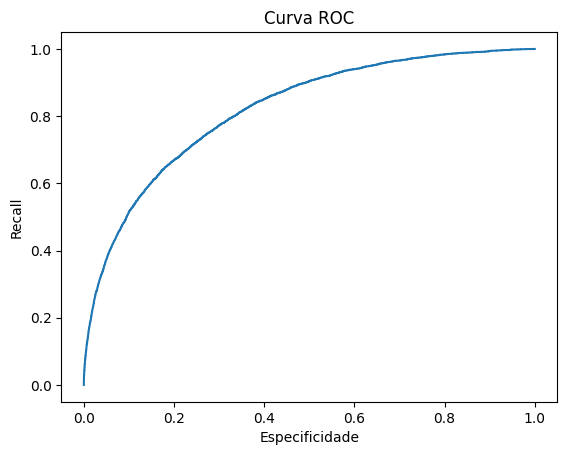

In [16]:
fpr, tpr, corte = metrics.roc_curve(Y_teste, 1-pred_Y)

plt.plot(fpr, tpr)
plt.xlabel('Especificidade')
plt.ylabel('Recall')
plt.title('Curva ROC')
plt.show()

# Análise de Ponto de Corte

In [17]:
Y_teste_p_maus = 1 - Y_teste.astype('int')

In [19]:
# Definindo os thresholds
threshold1 = 0.840
threshold2 = 0.946
threshold3 = 0.948

previsoes_threshold1 = (pred_Y < threshold1).astype(int)

sum(previsoes_threshold1)

5798

## Matriz de Confusão e medidas de desempenho

In [46]:
matriz_confusao = confusion_matrix(previsoes_threshold1,Y_teste)
matriz_confusao_df = pd.DataFrame(
    matriz_confusao,
    index=['Classe 0 (Previsto)', 'Classe 1 (Previsto)'],
    columns=['Classe 0 (Real)', 'Classe 1 (Real)']
)

print(matriz_confusao_df)

                     Classe 0 (Real)  Classe 1 (Real)
Classe 0 (Previsto)            73965             2707
Classe 1 (Previsto)             4111             1687


In [56]:
VN,FN,FP,VP = matriz_confusao.ravel()

# Calculando as métricas
sensibilidade = recall_score(Y_teste, previsoes_threshold1)
especificidade = VN/(VN+FP)
precisao = precision_score(Y_teste, previsoes_threshold1)
vpn = VN/(VN+FN)
f1 = f1_score(Y_teste, previsoes_threshold1)
acuracia = accuracy_score(Y_teste, previsoes_threshold1)

# Exibindo as métricas
print("Sensibilidade:", sensibilidade)
print("Especificidade:", especificidade)
print("Precisão:", precisao)
print("VPN:", vpn)
print("F1:", f1)
print("Acurácia:", acuracia)


Sensibilidade: 0.38393263541192535
Especificidade: 0.947346175521287
Precisão: 0.29096240082787167
VPN: 0.9646937604340567
F1: 0.33104395604395603
Acurácia: 0.917327513035043


In [67]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]
print(X_teste.shape)

(82470, 213)


## KS

In [121]:
from scipy.stats import ks_2samp
predicoes_df = pd.DataFrame(predicoes, columns=["Prob_Classe_0", "Prob_Classe_1"], index=X_teste.index)
predicoes_df = predicoes_df.reset_index(drop=True)

cal_KS = Y_teste.reset_index(drop=True)
teste_com_predicoes = pd.concat([cal_KS, predicoes_df], axis=1)

ks_2samp(teste_com_predicoes[teste_com_predicoes["var_resposta"] == 1 ]['Prob_Classe_0'],  teste_com_predicoes[teste_com_predicoes["var_resposta"] == 0 ]['Prob_Classe_0']) #0.4750229302853798


KstestResult(statistic=0.4750229302853798, pvalue=0.0, statistic_location=0.9482837133961924, statistic_sign=1)

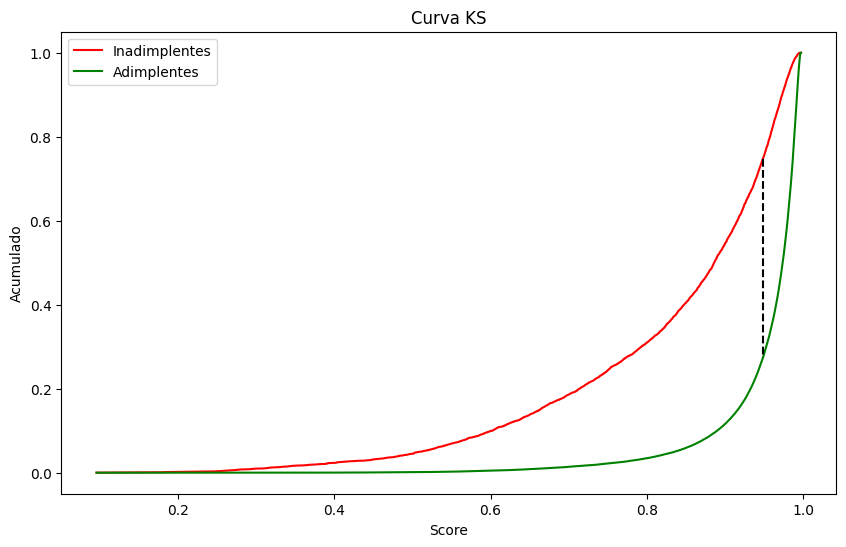

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


clientes_maus = teste_com_predicoes[teste_com_predicoes["var_resposta"] == 1 ]['Prob_Classe_0'] # Scores para clientes maus
clientes_bons = teste_com_predicoes[teste_com_predicoes["var_resposta"] == 0 ]['Prob_Classe_0']  # Scores para clientes bons

# Calcular CDF
x_maus = np.sort(clientes_maus)
y_maus = np.arange(1, len(x_maus) + 1) / len(x_maus)

x_bons = np.sort(clientes_bons)
y_bons = np.arange(1, len(x_bons) + 1) / len(x_bons)

# Calcular a diferença entre as CDFs
x_combined = np.unique(np.concatenate((x_maus, x_bons)))
cdf_maus = np.interp(x_combined, x_maus, y_maus, left=0, right=1)
cdf_bons = np.interp(x_combined, x_bons, y_bons, left=0, right=1)

# Calcular KS
ks_values = np.abs(cdf_maus - cdf_bons)
ks = np.max(ks_values)
ks_index = np.argmax(ks_values)
ks_x = x_combined[ks_index]
ks_y_maus = cdf_maus[ks_index]
ks_y_bons = cdf_bons[ks_index]

# Plotar CDF
plt.figure(figsize=(10, 6))
plt.plot(x_combined, cdf_maus, color='red', label='Inadimplentes')
plt.plot(x_combined, cdf_bons, color='green', label='Adimplentes')

# Linha conectando as CDFs no ponto KS
plt.plot([ks_x, ks_x], [ks_y_maus, ks_y_bons], color='black', linestyle='--')

plt.xlabel('Score')
plt.ylabel('Acumulado')
plt.title('Curva KS')
plt.legend()
#plt.grid()
#plt.text(ks_x, (ks_y_maus + ks_y_bons) / 2, f'KS = {ks:.2f}', fontsize=12, ha='left')

plt.show()

## Teste: SHAP

In [110]:
# pip install shap

In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(class_lgbm)


In [ ]:
shap_values = explainer(X_treino)

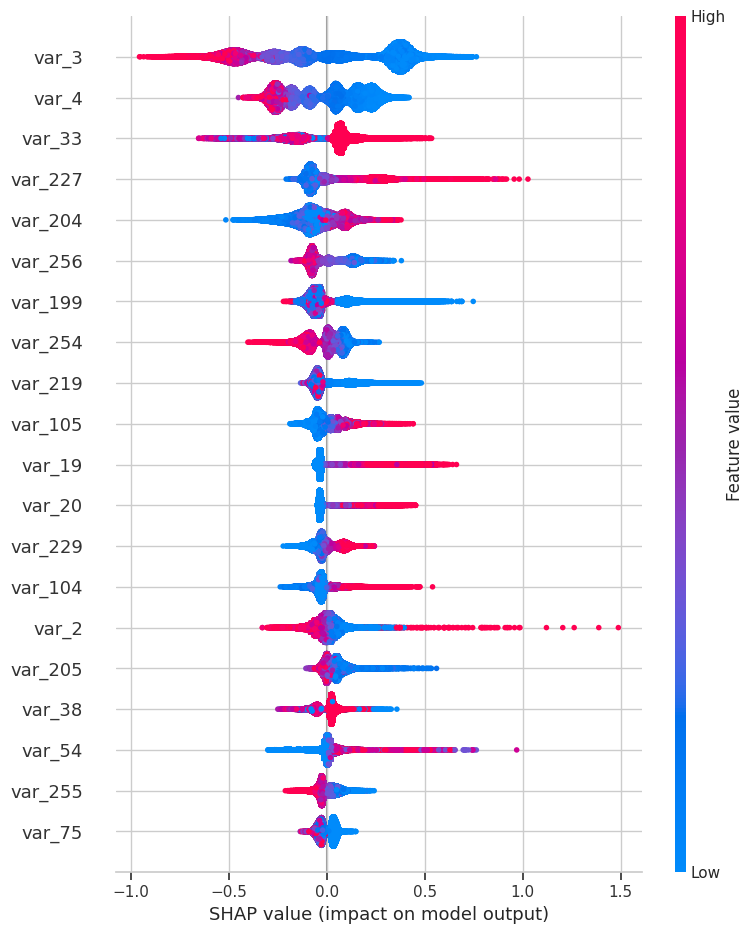

In [ ]:
shap.summary_plot(shap_values, X_treino,plot_type="dot")

In [111]:
# shap.dependence_plot('var_2', shap_values, X_treino)

## Features mais importantes


<Figure size 3600x2200 with 0 Axes>

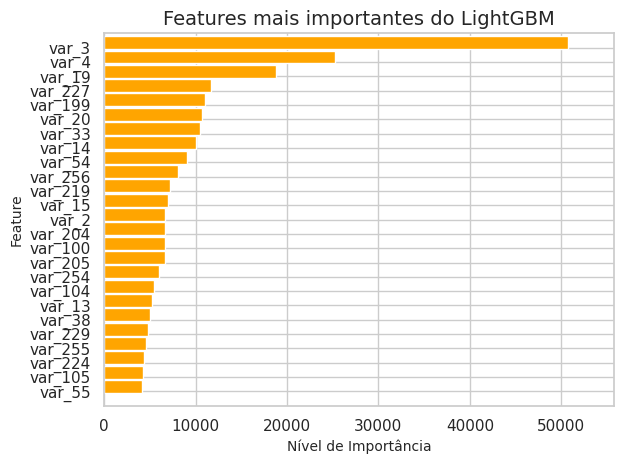

In [112]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(36, 22))
sns.set(style="whitegrid")
ax = lgb.plot_importance(class_lgbm, importance_type='gain', max_num_features=25, color='orange')

# Remover os valores na frente das barras
for t in ax.texts:
    t.set_text('')

# Ajustar a largura das barras
for patch in ax.patches:
    patch.set_height(0.9)  # Ajustar a altura das barras

plt.title('Features mais importantes do LightGBM', fontsize=14)
plt.xlabel('Nível de Importância', fontsize=10)
plt.ylabel('Feature', fontsize=10)
plt.tight_layout()
plt.show()

# Descritiva

In [126]:
teste_com_predicoes['var_resposta'] = teste_com_predicoes['var_resposta'].astype('category')

## Boxplot

<ipython-input-125-068c5675846d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=teste_com_predicoes, x='var_resposta', y='Prob_Classe_0', palette=["green", "red"])


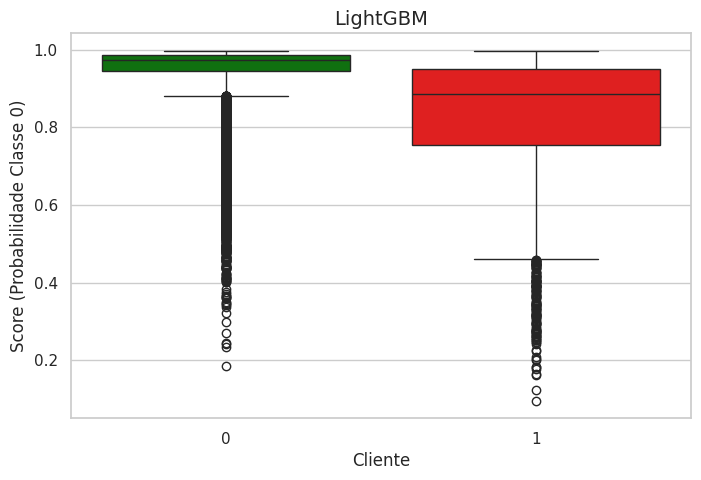

In [125]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=teste_com_predicoes, x='var_resposta', y='Prob_Classe_0', palette=["green", "red"])

plt.title('LightGBM', fontsize=14)
plt.xlabel('Cliente', fontsize=12)
plt.ylabel('Score (Probabilidade Classe 0)', fontsize=12)
plt.xticks([0, 1], labels=['0', '1'])  #
plt.show()


## Densidade

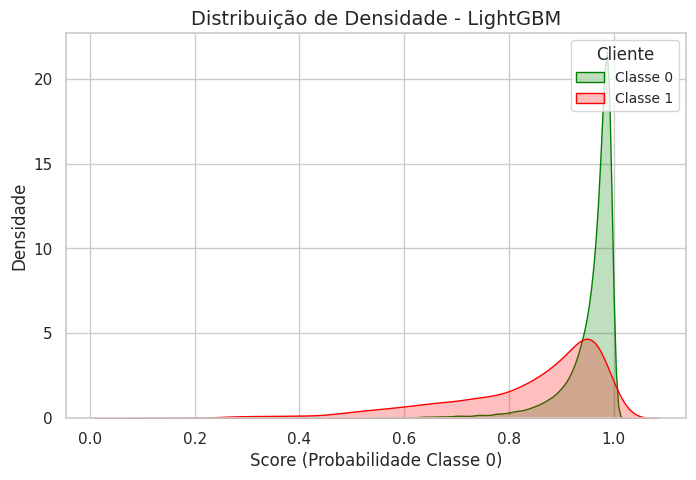

In [127]:
plt.figure(figsize=(8, 5))

sns.kdeplot(data=teste_com_predicoes[teste_com_predicoes['var_resposta'] == 0],
            x='Prob_Classe_0',
            fill=True,
            color="green",
            label="Classe 0")
sns.kdeplot(data=teste_com_predicoes[teste_com_predicoes['var_resposta'] == 1],
            x='Prob_Classe_0',
            fill=True,
            color="red",
            label="Classe 1")


plt.title('Distribuição de Densidade - LightGBM', fontsize=14)
plt.xlabel('Score (Probabilidade Classe 0)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(title='Cliente', fontsize=10, title_fontsize=12)
plt.show()


## Gráfico frequência versus taxa de inadimplência

In [129]:
bins = np.arange(0, 1100, 100)  # Intervalos de 0-100, 101-200, ..., 901-1000
teste_com_predicoes['Score_bin'] = pd.cut(teste_com_predicoes['Prob_Classe_0']*1000, bins=bins, right=False)

In [132]:
# Calcular frequência e taxa de inadimplência
freq = teste_com_predicoes.groupby('Score_bin').size()  # Contagem de observações
teste_com_predicoes['var_resposta'] = pd.to_numeric(teste_com_predicoes['var_resposta'], errors='coerce')
inadimplencia = teste_com_predicoes.groupby('Score_bin')['var_resposta'].mean()
inadimplencia

<ipython-input-132-69e15729090a>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq = teste_com_predicoes.groupby('Score_bin').size()  # Contagem de observações
<ipython-input-132-69e15729090a>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  inadimplencia = teste_com_predicoes.groupby('Score_bin')['var_resposta'].mean()


,var_resposta
Score_bin,
"[0, 100)",1.000000
"[100, 200)",0.857143
"[200, 300)",0.875000
"[300, 400)",0.813333
"[400, 500)",0.519337
"[500, 600)",0.465887
"[600, 700)",0.349541
"[700, 800)",0.253620
"[800, 900)",0.140441


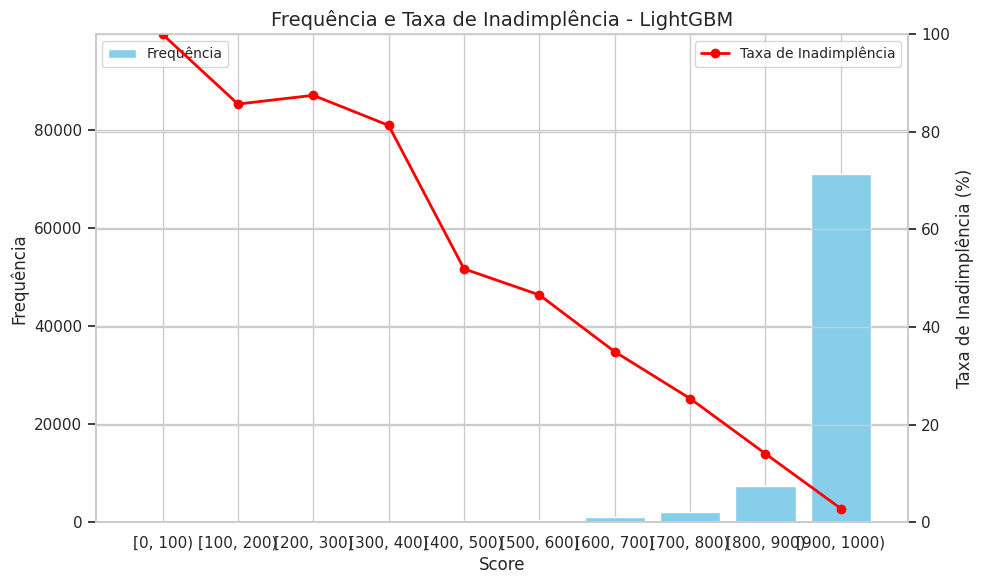

In [139]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(freq.index.astype(str), freq, color='skyblue', label='Frequência', width=0.8)
ax1.set_xlabel('Score', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_ylim(0, freq.max() * 1.4)  # Ajustar limite do eixo Y

# Gráfico de linha para taxa de inadimplência
ax2 = ax1.twinx()
ax2.plot(freq.index.astype(str), inadimplencia * 100, color='red', marker='o', label='Taxa de Inadimplência', linewidth=2)
ax2.set_ylabel('Taxa de Inadimplência (%)', fontsize=12)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)

# Títulos e legenda
plt.title('Frequência e Taxa de Inadimplência - LightGBM', fontsize=14)
fig.tight_layout()
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.show()
